### Import Necessary Libraries

In [ ]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.4 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 11.8 MB/s eta 0:00:00
  Using cached fastdtw-0.3.4.tar.gz (133 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512575 sha256=1a1259fe99af5437d28fa53e32543d499b3d93f5da215406b3b63c4e8db2cbdd
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from qiskit import BasicAer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC

algorithm_globals.random_seed = 12345

warnings.filterwarnings("ignore")

### Data Collection

In [79]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [80]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [81]:
!kaggle datasets download -d katalniraj/adni-extracted-axial

 82% 83.0M/102M [00:01<00:00, 78.4MB/s]
100% 102M/102M [00:01<00:00, 97.8MB/s] 


In [82]:
import zipfile

with zipfile.ZipFile('/content/adni-extracted-axial.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/alzheimer-mri-dataset')

In [83]:
path = r"/content/alzheimer-mri-dataset/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [84]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [85]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [86]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [87]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


### Data Visualization

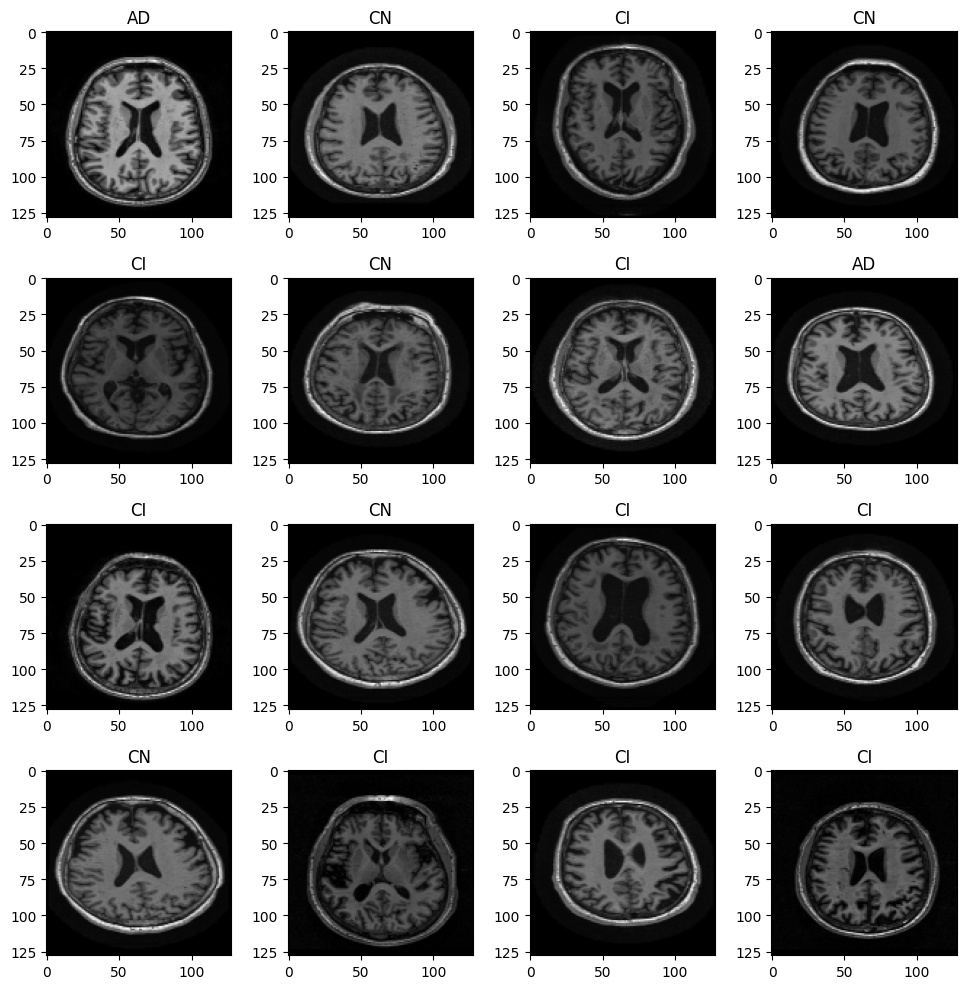

In [ ]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

AD


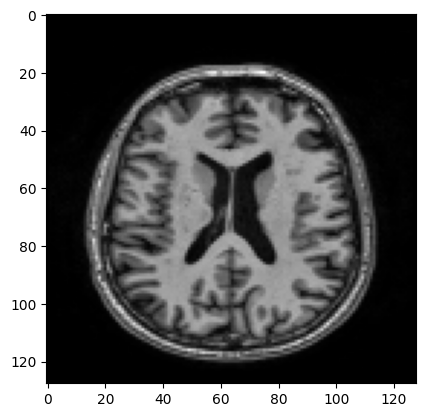

CN


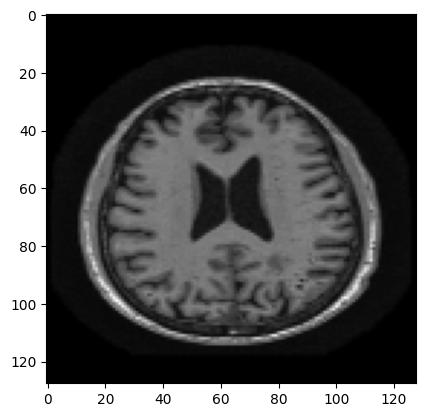

CI


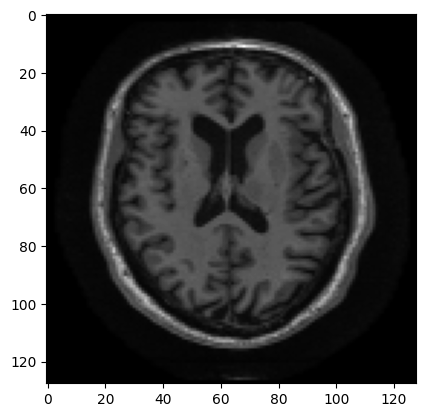

In [ ]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [88]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
dtype: int64


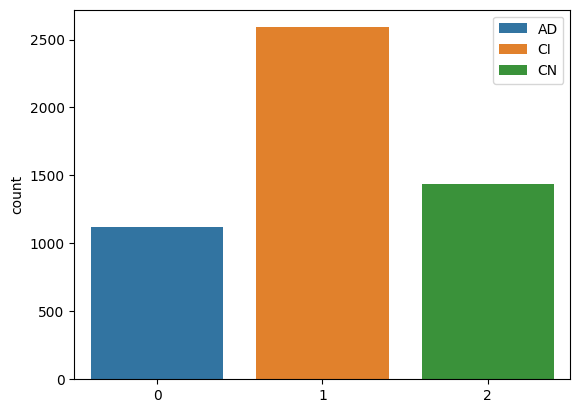

In [ ]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

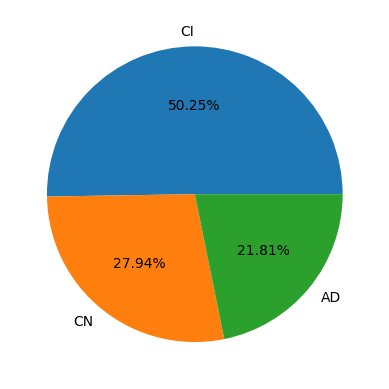

In [ ]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [89]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [90]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1

X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


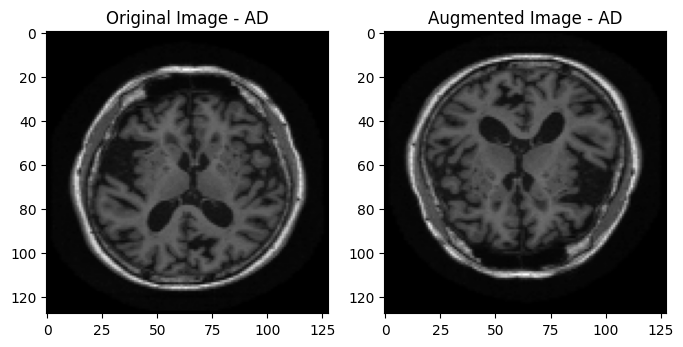

In [92]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

original_img = array_to_img(X_new[0])
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.gray()
plt.title(f'Original Image - {label_map[y_new[0]]}')

augmented_img = data_augmentation(img_to_array(original_img))
augmented_img_pil = array_to_img(augmented_img)
plt.subplot(1, 2, 2)
plt.imshow(augmented_img_pil)
plt.gray()
plt.title(f'Augmented Image - {label_map[y_new[0]]}')

plt.show()

In [ ]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [ ]:
print(pd.Series(y).value_counts())

0    3002
2    3002
1    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [ ]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [ ]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


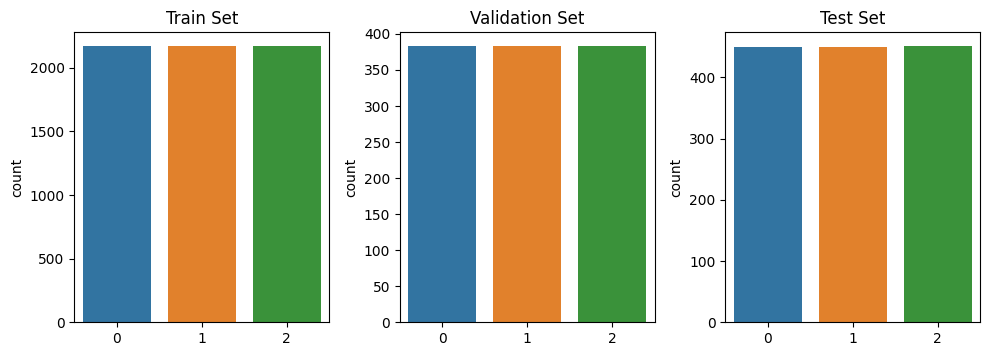

In [ ]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

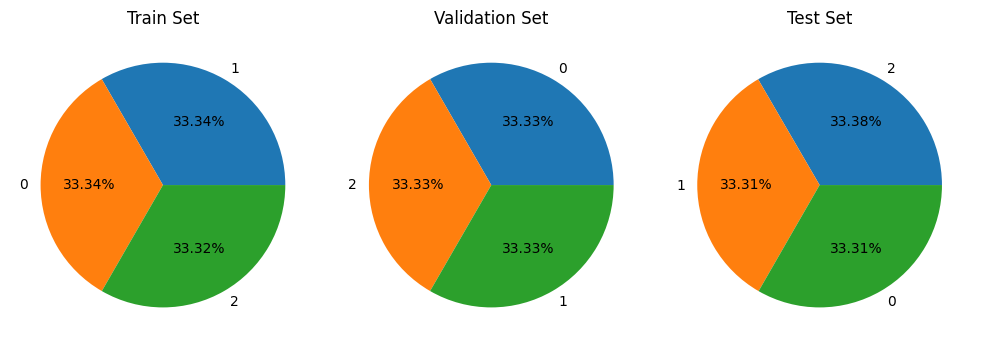

In [ ]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

### Feature Extraction Using VGG16

In [71]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
dense_layer = Dense(10, activation='softmax')(vgg_model.output)
model = Model(inputs=vgg_model.input, outputs=dense_layer)
feature_maps = []
labels = []

In [72]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

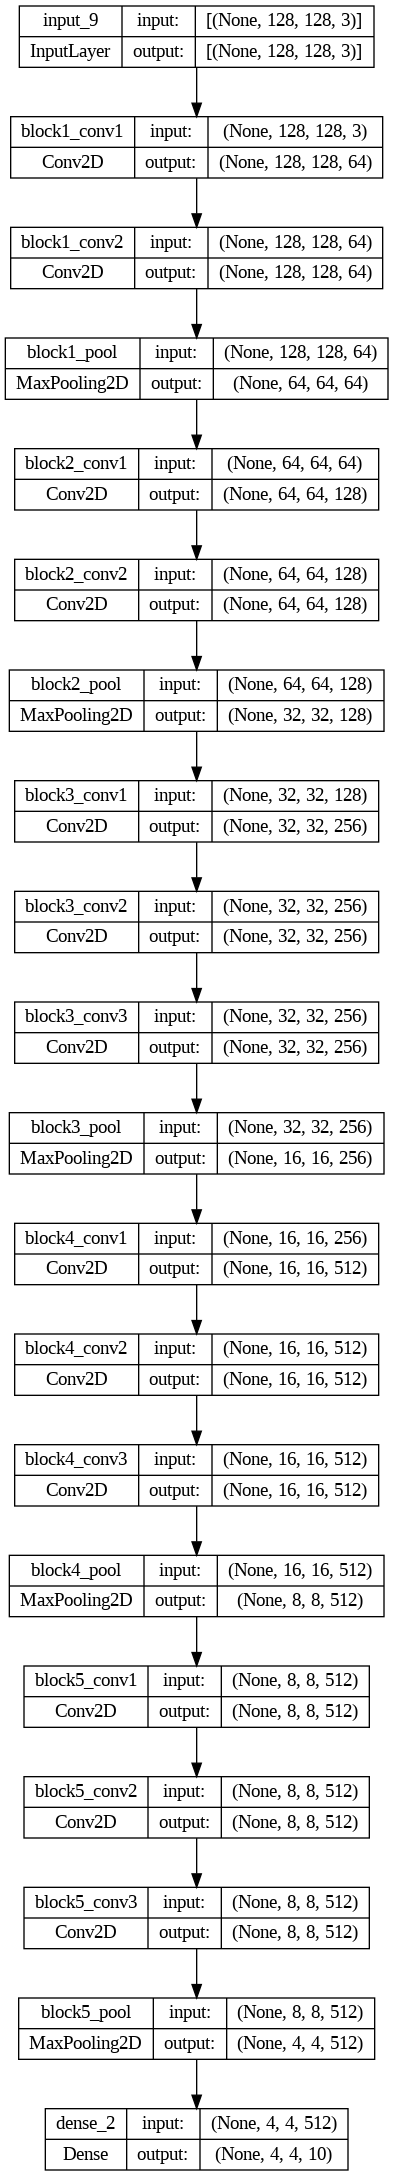

In [73]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

In [74]:
for i in range(len(X_train)):
    img_array = preprocess_input(np.expand_dims(X_train[i], axis=0))
    features = model.predict(img_array)
    features_flatten = features.flatten()
    feature_maps.append(features_flatten)
    labels.append(y_train[i])
feature_maps = np.array(feature_maps)
labels = np.array(labels)

print("Feature extraction completed for the training set.")

Feature extraction completed for the training set.


In [75]:
feature_maps_test=[]
labels_test=[]
for i in range(len(X_test)):
    img_array = preprocess_input(np.expand_dims(X_train[i], axis=0))
    features = model.predict(img_array)
    features_flatten = features.flatten()
    feature_maps_test.append(features_flatten)
    labels.append(y_test[i])
feature_maps_test = np.array(feature_maps_test)
labels_test = np.array(labels_test)

print("Feature extraction completed for the test set.")

Feature extraction completed for the test set.


### Encoding the Feature Map and Instantiating the Quantum Kernel

In [46]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(feature_dimension=len(feature_maps[0]), reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

#### Using the Quantum Kernel with Classical SVM

In [76]:
from sklearn.svm import SVC

svc = SVC(kernel=kernel.evaluate)

svc.fit(feature_maps, labels)

score_callable_function = svc.score(feature_maps_test, labels_test)

print(f"Callable kernel classification test score: {score_callable_function}")

Callable kernel classification test score: 0.935


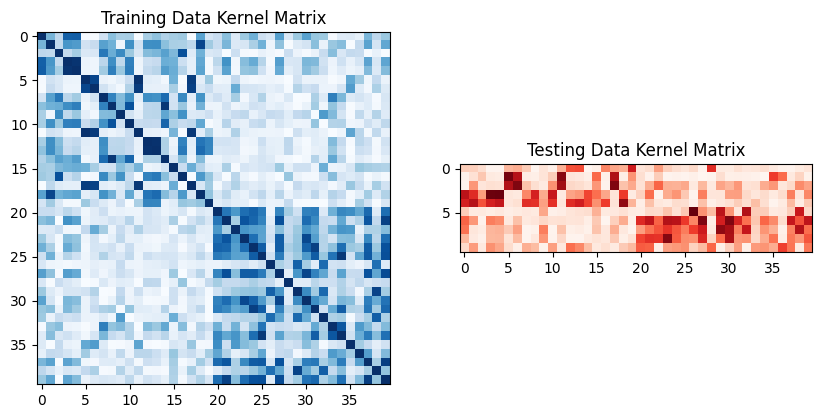

In [51]:
matrix_train = kernel.evaluate(x_vec=feature_maps)
matrix_test = kernel.evaluate(x_vec=feature_maps_test, y_vec=feature_maps)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training Data Kernel Matrix")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing Data Kernel Matrix")

plt.show()

### Classifying Using Quantum SVM

In [78]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=kernel)

qsvc.fit(feature_maps, labels)

qsvc_score = qsvc.score(feature_maps_test, labels_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.982


### Performance Metrics

In [ ]:
y_train_pred = svc.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 [==============================] - 1s 6ms/step
tf.Tensor(
[[2164    3    2]
 [   0 2165    4]
 [   3   11 2154]], shape=(3, 3), dtype=int32)


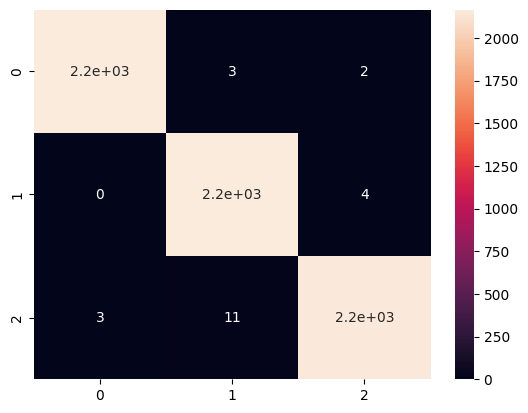

In [ ]:
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2164
True Negatives : 4334
False Positives : 3
False Negatives : 5

Precision : 0.9986155976003692
Recall (Sensitivity) : 0.9976947902259106
F1-Score : 0.9981549815498155


Class CI : 

True Positives : 2165
True Negatives : 4323
False Positives : 14
False Negatives : 4

Precision : 0.9935750344194585
Recall (Sensitivity) : 0.9981558321807285
F1-Score : 0.9958601655933763


Class CN : 

True Positives : 2154
True Negatives : 4332
False Positives : 6
False Negatives : 14

Precision : 0.9972222222222222
Recall (Sensitivity) : 0.9935424354243543
F1-Score : 0.9953789279112754


In [ ]:
clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169
           1       0.99      1.00      1.00      2169
           2       1.00      0.99      1.00      2168

    accuracy                           1.00      6506
   macro avg       1.00      1.00      1.00      6506
weighted avg       1.00      1.00      1.00      6506

